# Project Part 4

## Research questions:

1. How was unemployment affected by the covid induced pandemic? 
2. What was the relationship between the number of covid cases and the unemployment insurance claims in Harris County

The research questions for this analysis have been answered using a combination of analytical methods. The first step of the analysis is to standardize all the 3 datasets into monthly data by aggregating the base data and the weekly insurance claims.


### First we install all requitred dependencies
Import necessary packages

#### pip install ruptures

In [153]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import ruptures as rpt
import warnings
warnings.filterwarnings('ignore')

### Assumptions made for the analysis:
1. confirmed cases = total infection
2. mask mandates null does not mean there is no making policy in place.   We impute it as unknown
       
Population :
    April 20 : 4,731,145
    July 21 :  4,728,030

## Reading data from the given files

In [154]:
conf_cases = pd.read_csv("RAW_us_confirmed_cases.csv")
mask_use_by_county = pd.read_csv("mask-use-by-county.csv")
mm = pd.read_csv("U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv")

#Additional data for part 3 analysis 
unemp= pd.read_csv("UNRATE.csv")
claims= pd.read_csv("claims.csv")

In [155]:
conf_cases.head()

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/22/22,10/23/22,10/24/22,10/25/22,10/26/22,10/27/22,10/28/22,10/29/22,10/30/22,10/31/22
0,Alabama,Autauga,84001001,US,USA,840,1001.0,US,32.539527,-86.644082,...,18480,18480,18480,18480,18480,18511,18511,18511,18511,18511
1,Alabama,Baldwin,84001003,US,USA,840,1003.0,US,30.727750,-87.722071,...,65895,65895,65895,65895,65895,65973,65973,65973,65973,65973
2,Alabama,Barbour,84001005,US,USA,840,1005.0,US,31.868263,-85.387129,...,6926,6926,6926,6926,6926,6930,6930,6930,6930,6930
3,Alabama,Bibb,84001007,US,USA,840,1007.0,US,32.996421,-87.125115,...,7560,7560,7560,7560,7560,7575,7575,7575,7575,7575
4,Alabama,Blount,84001009,US,USA,840,1009.0,US,33.982109,-86.567906,...,17286,17286,17286,17286,17286,17320,17320,17320,17320,17320


In [156]:
unemp.head()

,DATE,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5


In [157]:
unemp.sort_values(by="DATE", ascending=True  )

,DATE,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5
...,...,...
894,2022-07-01,3.5
895,2022-08-01,3.7
896,2022-09-01,3.5
897,2022-10-01,3.7


### Pre process data to merge with base data

In [158]:
unemp1 = unemp.loc[unemp['DATE'] >= "1990-01-01"] 

In [159]:
unemp1 = unemp1.rename(columns={'DATE': 'Date'})
unemp1.head()

,Date,UNRATE
504,1990-01-01,5.4
505,1990-02-01,5.3
506,1990-03-01,5.2
507,1990-04-01,5.4
508,1990-05-01,5.4


In [160]:
claims.head()

,week_ended,reflecting_week_end,fips_code,state_name,initial_claims,continued_claims,covered_employment,insured_unemployment_rate,Unnamed: 8
0,8/28/2021,8/21/2021,04000US48,Texas,19274,166925,NaN,NaN,8/1/2021
1,8/21/2021,8/14/2021,04000US48,Texas,20335,179271,NaN,NaN,8/1/2021
2,8/14/2021,8/7/2021,04000US48,Texas,23375,191169,11848728.0,1.61,8/1/2021
3,8/7/2021,7/31/2021,04000US48,Texas,31042,190232,11848728.0,1.61,8/1/2021
4,7/31/2021,7/24/2021,04000US48,Texas,30138,210422,11848728.0,1.78,7/1/2021


In [161]:
claims = claims.rename(columns={'Unnamed: 8': 'Date'})
claims.sort_values(by="Date", ascending=True  )
claims.head()

,week_ended,reflecting_week_end,fips_code,state_name,initial_claims,continued_claims,covered_employment,insured_unemployment_rate,Date
0,8/28/2021,8/21/2021,04000US48,Texas,19274,166925,NaN,NaN,8/1/2021
1,8/21/2021,8/14/2021,04000US48,Texas,20335,179271,NaN,NaN,8/1/2021
2,8/14/2021,8/7/2021,04000US48,Texas,23375,191169,11848728.0,1.61,8/1/2021
3,8/7/2021,7/31/2021,04000US48,Texas,31042,190232,11848728.0,1.61,8/1/2021
4,7/31/2021,7/24/2021,04000US48,Texas,30138,210422,11848728.0,1.78,7/1/2021


In [162]:
claims1 = claims.loc[claims['Date'] >= "2020-01-01"] 
claims1.reset_index()
claims_df = claims1.groupby('Date').mean().reset_index()

In [164]:
claims_df.head()

,Date,initial_claims,continued_claims,covered_employment,insured_unemployment_rate
0,3/1/1987,18462.75,179384.50,6386117.0,2.810
1,3/1/1988,14579.50,128155.00,6194144.0,2.070
2,3/1/1989,13070.50,123485.25,6285338.0,1.965
3,3/1/1990,14377.80,126656.40,6471125.2,1.958
4,3/1/1991,14488.00,143829.40,6662385.8,2.160


In [167]:
claims_df = claims1.drop(['week_ended', 'reflecting_week_end', 'fips_code', 'state_name'], axis=1)

#### Filter out for the required county : Harris County in Texas

In [168]:
Harris = conf_cases[(conf_cases["Province_State"] == "Texas") & (conf_cases["Admin2"] == "Harris")]
Harris.head()

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/22/22,10/23/22,10/24/22,10/25/22,10/26/22,10/27/22,10/28/22,10/29/22,10/30/22,10/31/22
2800,Texas,Harris,84048201,US,USA,840,48201.0,US,29.858649,-95.393395,...,1219126,1219126,1219564,1219564,1219873,1219873,1220195,1220195,1220195,1220616


## Base data pre processing

Data needs to be cleaned and standardized 

In [169]:
#The first few columns are general info about the state
Harris_info = conf_cases[conf_cases.columns[0:11]]
# FIPS needed to extraxt info from mask_use_by_county
Harris_FIPS = conf_cases["FIPS"].values[0]

In [170]:
Harris_FIPS

1001.0

In [171]:
mask_use_by_county.head()

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,0.053,0.074,0.134,0.295,0.444
1,1003,0.083,0.059,0.098,0.323,0.436
2,1005,0.067,0.121,0.120,0.201,0.491
3,1007,0.020,0.034,0.096,0.278,0.572
4,1009,0.053,0.114,0.180,0.194,0.459


In [172]:
mask_use_by_county

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,0.053,0.074,0.134,0.295,0.444
1,1003,0.083,0.059,0.098,0.323,0.436
2,1005,0.067,0.121,0.120,0.201,0.491
3,1007,0.020,0.034,0.096,0.278,0.572
4,1009,0.053,0.114,0.180,0.194,0.459
...,...,...,...,...,...,...
3137,56037,0.061,0.295,0.230,0.146,0.268
3138,56039,0.095,0.157,0.160,0.247,0.340
3139,56041,0.098,0.278,0.154,0.207,0.264
3140,56043,0.204,0.155,0.069,0.285,0.287


In [173]:
Harris_mask_use = mask_use_by_county[mask_use_by_county["COUNTYFP"] == Harris_FIPS]
mm.head()

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
0,AL,Autauga County,1,1,4/10/2020,2,NaN,NaN,NaN,NaN
1,AL,Autauga County,1,1,4/11/2020,2,NaN,NaN,NaN,NaN
2,AL,Autauga County,1,1,4/12/2020,2,NaN,NaN,NaN,NaN
3,AL,Autauga County,1,1,4/13/2020,2,NaN,NaN,NaN,NaN
4,AL,Autauga County,1,1,4/14/2020,2,NaN,NaN,NaN,NaN


In [174]:
#mask_mandates_april_2020_aug_2021["State_Tribe_Territory"].value_counts()
mm["County_Name"].value_counts()

Washington County    14790
Jefferson County     12325
Franklin County      11832
Lincoln County       11339
Jackson County       11339
                     ...  
Norfolk County         493
Nantucket County       493
Hampden County         493
Dukes County           493
St. John Island        493
Name: County_Name, Length: 1968, dtype: int64

In [175]:
Harris_mask_mandates = mm[(mm["State_Tribe_Territory"] == "TX") & (mm['County_Name'] == 'Harris County')]
Harris_mask_mandates.head()

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
697718,TX,Harris County,48,201,4/10/2020,2,NaN,NaN,NaN,NaN
697719,TX,Harris County,48,201,4/11/2020,2,NaN,NaN,NaN,NaN
697720,TX,Harris County,48,201,4/12/2020,2,NaN,NaN,NaN,NaN
697721,TX,Harris County,48,201,4/13/2020,2,NaN,NaN,NaN,NaN
697722,TX,Harris County,48,201,4/14/2020,2,NaN,NaN,NaN,NaN


In [176]:
Harris_mask_mandates["Face_Masks_Required_in_Public"].fillna("Unknown",inplace=True)
Harris_mask_mandates["Face_Masks_Required_in_Public"].value_counts()

Yes        250
No         159
Unknown     84
Name: Face_Masks_Required_in_Public, dtype: int64

In [177]:
#To analyse the number of cases
Harris_cases = Harris.iloc[:,12:].transpose().reset_index()

In [178]:
Harris_cases.columns=['Date', 'Number_of_cases']

In [179]:
Harris_cases.head()

,Date,Number_of_cases
0,1/23/20,0
1,1/24/20,0
2,1/25/20,0
3,1/26/20,0
4,1/27/20,0


#### Convert Date to DateTime and sort ascending

In [180]:
Harris_cases["Date"] = pd.to_datetime(Harris_cases["Date"], format="%m/%d/%y")
#Harris_cases["Date"] = Harris_cases["Date"].astype()
Harris_cases = Harris_cases.sort_values(by='Date')

In [181]:
Harris_cases["Date"].value_counts()

2020-01-23    1
2021-12-04    1
2021-11-21    1
2021-11-22    1
2021-11-23    1
             ..
2020-12-30    1
2020-12-31    1
2021-01-01    1
2021-01-02    1
2022-10-31    1
Name: Date, Length: 1013, dtype: int64

In [182]:
Harris_cases.head()

,Date,Number_of_cases
0,2020-01-23,0
1,2020-01-24,0
2,2020-01-25,0
3,2020-01-26,0
4,2020-01-27,0


### Merge mask mandates to case data

In [183]:
mm_subset = Harris_mask_mandates[['date' , 'Face_Masks_Required_in_Public']]
mm_subset["Date"] = pd.to_datetime(mm_subset["date"], format="%m/%d/%Y")
mm_subset.drop( columns= "date" , inplace = True)
mm_subset.head()

,Face_Masks_Required_in_Public,Date
697718,Unknown,2020-04-10
697719,Unknown,2020-04-11
697720,Unknown,2020-04-12
697721,Unknown,2020-04-13
697722,Unknown,2020-04-14


In [184]:
df = Harris_cases.merge(mm_subset, on ='Date', how='left')

In [185]:
df['Date'].value_counts()

2020-01-23    1
2021-12-04    1
2021-11-21    1
2021-11-22    1
2021-11-23    1
             ..
2020-12-30    1
2020-12-31    1
2021-01-01    1
2021-01-02    1
2022-10-31    1
Name: Date, Length: 1013, dtype: int64

In [186]:
unemp1[["Date"]] = unemp1[["Date"]].apply(pd.to_datetime)
#pd.to_datetime(, format='%Y%m%d', errors='ignore')

In [187]:
# Filter data for specific weekday (tuesday)
df['monthstart'] = df['Date'].dt.is_month_start
filtered_df = df.loc[df['monthstart'] == True]

In [188]:
df1 = filtered_df.merge(unemp1, on='Date', how='left')

In [189]:
df1.head()

,Date,Number_of_cases,Face_Masks_Required_in_Public,monthstart,UNRATE
0,2020-02-01,0,NaN,True,3.5
1,2020-03-01,0,NaN,True,4.4
2,2020-04-01,1231,NaN,True,14.7
3,2020-05-01,8488,Unknown,True,13.2
4,2020-06-01,21012,Unknown,True,11.0


In [190]:
claims_df[["Date"]] = claims_df[["Date"]].apply(pd.to_datetime)
df2 = df1.merge(claims_df, on='Date', how='left')
df2.head()

,Date,Number_of_cases,Face_Masks_Required_in_Public,monthstart,UNRATE,initial_claims,continued_claims,covered_employment,insured_unemployment_rate
0,2020-02-01,0,NaN,True,3.5,NaN,NaN,NaN,NaN
1,2020-03-01,0,NaN,True,4.4,276185.0,144697.0,12236594.0,1.18
2,2020-03-01,0,NaN,True,4.4,155426.0,126427.0,12236594.0,1.03
3,2020-03-01,0,NaN,True,4.4,16176.0,127905.0,12236594.0,1.05
4,2020-03-01,0,NaN,True,4.4,14355.0,125252.0,12236594.0,1.02


## Visual inspection : the number of covid cases over time with unemployment rate

In [191]:
df2 = df2.rename(columns={'UNRATE': 'Unemployment_Rate'})

No handles with labels found to put in legend.
findfont: Font family ['Roboto'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Roboto'] not found. Falling back to DejaVu Sans.


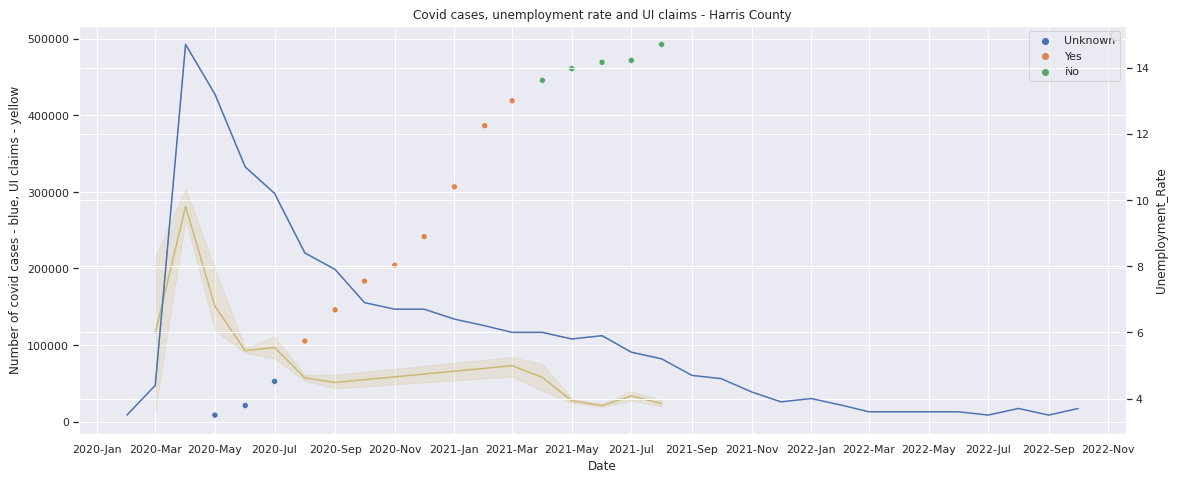

In [192]:
figure(figsize=(15, 6), dpi=90)
sns.set(context="paper", font="Roboto")

sns.scatterplot(x = "Date", y = "Number_of_cases" , data = df2, hue='Face_Masks_Required_in_Public'   )
plt.ylabel('Number of covid cases - blue, UI claims - yellow')
sns.lineplot(x = "Date", y = "initial_claims", data= df2, color="y")
sns.lineplot(x = "Date", y = "Unemployment_Rate", data= df2, color="b", ax = plt.twinx())


dtFmt = mdates.DateFormatter('%Y-%b')
plt.gca().xaxis.set_major_formatter(dtFmt) 

plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))

plt.xlabel('Date')

plt.title('Covid cases, unemployment rate and UI claims - Harris County')
plt.savefig('Covid cases, unemployment rate and UI claims - Harris County.jpeg')
plt.show()

We see that as the cumulative active cases rise, the unemployment rate peaks, and then gradually decreases. This can be attributed to the vaccination becoming available in Harris County, Texas in August 2021. 
The masking mandates, in addition to the welfare norms introduced my the government also impact unemployment and UI claims.

## We see the trends for monthly new cases instead of cumulative cases

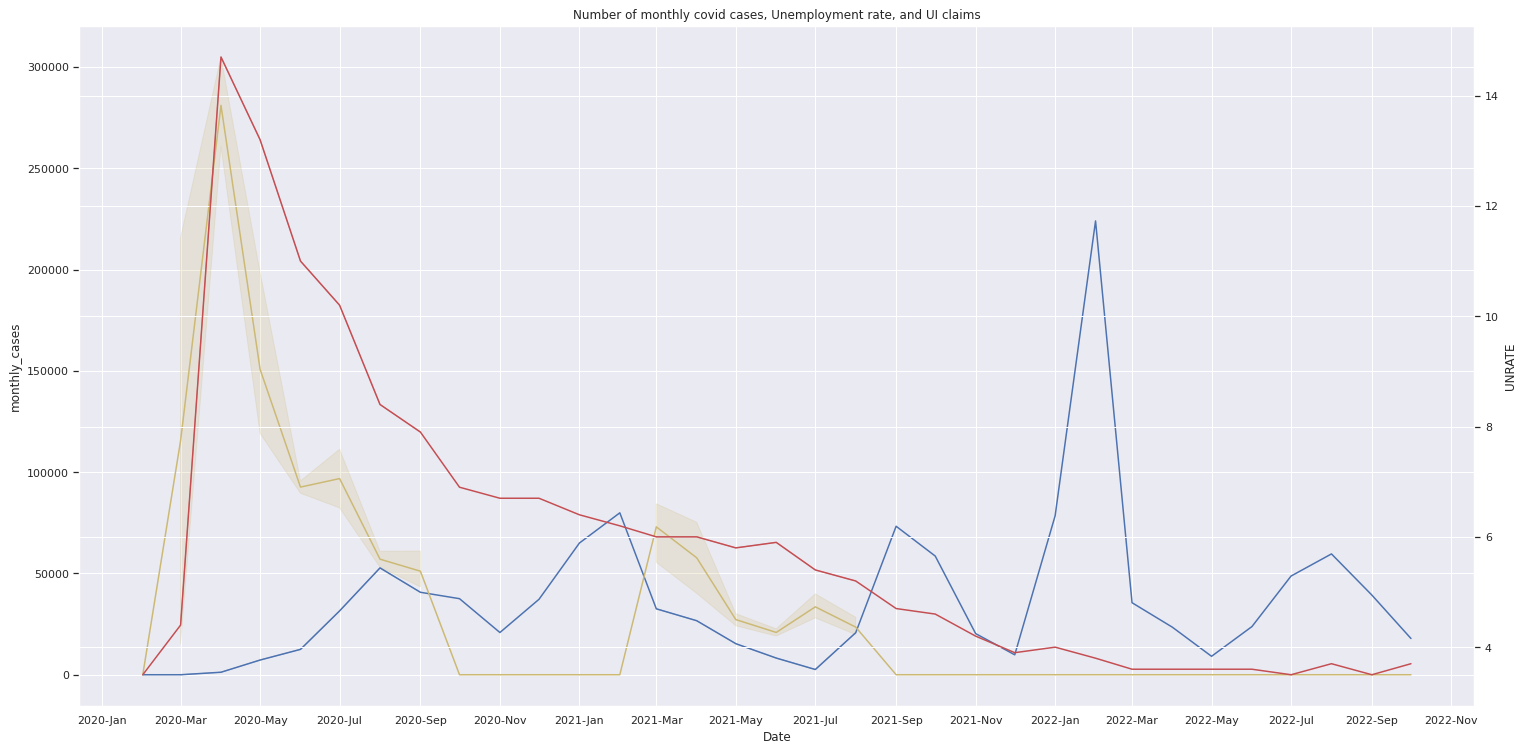

In [196]:
figure(figsize=(20, 10), dpi=90)

sns.lineplot(x = "Date", y = "monthly_cases", data= df5, color="b")

sns.lineplot(x = "Date", y = "initial_claims", data= df5, color="y")
sns.lineplot(x = "Date", y = "UNRATE", data= df5, color="r",ax = plt.twinx())


dtFmt = mdates.DateFormatter('%Y-%b')
plt.gca().xaxis.set_major_formatter(dtFmt) 

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))


plt.title('Number of monthly covid cases, Unemployment rate, and UI claims')
plt.show()

There is no identifiable trend in the graph above.

## Calculate the number of daily cases from cumulative cases by subtracting the number of cases on the previous day.

In [58]:
df1['Number_of_daily_cases'] = df1['Number_of_cases'] - df1.shift(1)['Number_of_cases']
df1['Population'] = 4728030
df1['Infection_rate'] = df1['Number_of_daily_cases']/df1['Population']
df1.head()

,Date,Number_of_cases,Face_Masks_Required_in_Public,monthstart,UNRATE,Number_of_daily_cases,Population,Infection_rate
0,2020-02-01,0,NaN,True,3.5,NaN,4728030,NaN
1,2020-03-01,0,NaN,True,4.4,0.0,4728030,0.000000
2,2020-04-01,1231,NaN,True,14.7,1231.0,4728030,0.000260
3,2020-05-01,8488,Unknown,True,13.2,7257.0,4728030,0.001535
4,2020-06-01,21012,Unknown,True,11.0,12524.0,4728030,0.002649


In [60]:
df2 = df1.groupby(by='Date')['Number_of_daily_cases'].mean().reset_index()
df2.columns = ['Date','monthly_cases']
df2['Date'] = pd.to_datetime(df2['Date'])
df2.head()

,Date,monthly_cases
0,2020-02-01,NaN
1,2020-03-01,0.0
2,2020-04-01,1231.0
3,2020-05-01,7257.0
4,2020-06-01,12524.0


In [52]:
df3 = df2.merge(unemp1, on='Date', how='left')
df4 = df3.merge(claims_df, on='Date', how='left')
df4.head()

,Date,monthly_cases,UNRATE,initial_claims,continued_claims,covered_employment,insured_unemployment_rate
0,2020-02-01,NaN,3.5,NaN,NaN,NaN,NaN
1,2020-03-01,0.0,4.4,276185.0,144697.0,12236594.0,1.18
2,2020-03-01,0.0,4.4,155426.0,126427.0,12236594.0,1.03
3,2020-03-01,0.0,4.4,16176.0,127905.0,12236594.0,1.05
4,2020-03-01,0.0,4.4,14355.0,125252.0,12236594.0,1.02


In [53]:
df5 = df4.merge(mm_subset, on ='Date', how='left')
df5.head()

,Date,monthly_cases,UNRATE,initial_claims,continued_claims,covered_employment,insured_unemployment_rate,Face_Masks_Required_in_Public
0,2020-02-01,NaN,3.5,NaN,NaN,NaN,NaN,NaN
1,2020-03-01,0.0,4.4,276185.0,144697.0,12236594.0,1.18,NaN
2,2020-03-01,0.0,4.4,155426.0,126427.0,12236594.0,1.03,NaN
3,2020-03-01,0.0,4.4,16176.0,127905.0,12236594.0,1.05,NaN
4,2020-03-01,0.0,4.4,14355.0,125252.0,12236594.0,1.02,NaN


In [84]:
# Checking for nulls
df5['monthly_cases'].isnull().sum()

1

In [239]:
df5["Face_Masks_Required_in_Public"].value_counts()

Yes    8
No     5
Name: Face_Masks_Required_in_Public, dtype: int64

In [85]:
df5 = df5.fillna(0)

## The number of new confirmed cases per day

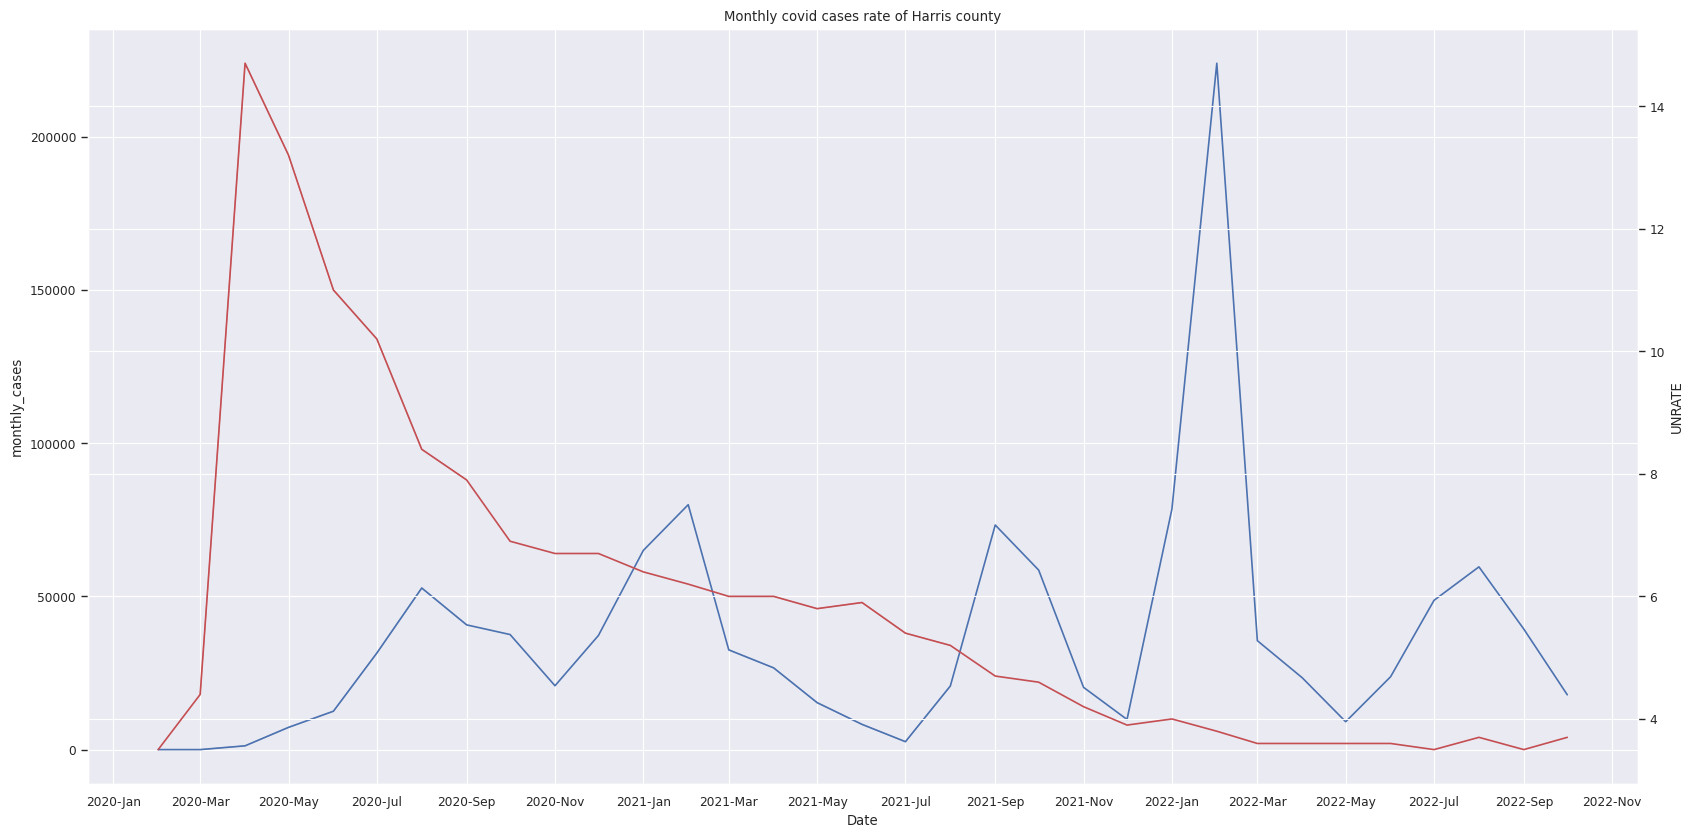

In [195]:
figure(figsize=(20, 10), dpi=100)
sns.lineplot(x = "Date", y = "monthly_cases", data=df5)
# Major ticks every half year, minor ticks every month,
sns.lineplot(x = "Date", y = "UNRATE", data= df5, color="r", ax = plt.twinx())

dtFmt = mdates.DateFormatter('%Y-%b')
plt.gca().xaxis.set_major_formatter(dtFmt) 

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))

plt.title('Monthly covid cases rate of Harris county')
plt.savefig('Monthly cases of Harris county with unemployment rate.jpeg')

plt.show()

We see that when the masking mandate was introduced there was a dip in the number of COVID cases, but then the cases started rising again. This decrease can also be attributed to vaccinations in addition to the masking policies.

## Correlation Plots

<AxesSubplot:xlabel='monthly_cases', ylabel='initial_claims'>

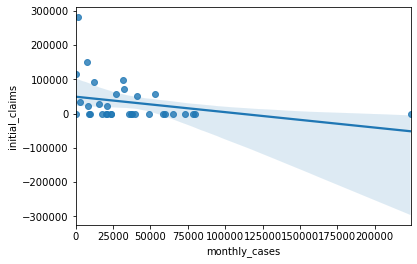

In [259]:
sns.regplot(x=df5["monthly_cases"], y=df5["initial_claims"])

Pearsons Correlation coefficient

In [142]:
df5['initial_claims'] = df5['initial_claims'].fillna(0)

from scipy.stats import pearsonr
 
# Import your data into Python

# Convert dataframe into series
list1 = df5['monthly_cases']
list2 = df5['initial_claims']
 
# Apply the pearsonr()
corr, _ = pearsonr(list1, list2)
print('Pearsons correlation between the number of covid cases and UI claims: %.3f' % corr)

Pearsons correlation between the number of covid cases and UI claims: -0.327


There is a weak but negative correlation. This can be attributed to the fact that as the number of cases increases, there are remedial policies brought about to tackle that problem.

<AxesSubplot:xlabel='monthly_cases', ylabel='UNRATE'>

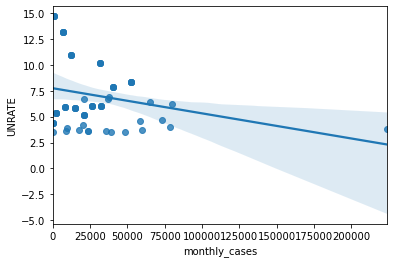

In [143]:
sns.regplot(x=df5["monthly_cases"], y=df5["UNRATE"])

Pearsons Correlation coefficient

In [144]:
df5['UNRATE'] = df5['UNRATE'].fillna(0)

from scipy.stats import pearsonr
 
# Import your data into Python

# Convert dataframe into series
list1 = df5['monthly_cases']
list2 = df5['UNRATE']
 
# Apply the pearsonr()
corr, _ = pearsonr(list1, list2)
print('Pearsons correlation between the number of covid cases and the unemployment rate: %.3f' % corr)

Pearsons correlation between the number of covid cases and the unemployment rate: -0.232


## Checking the assumptions of linearity

Linear regression needs the relationship between the independent and dependent variables to be linear. Let's use a pair plot to check the relation of independent variables with the Sales variable

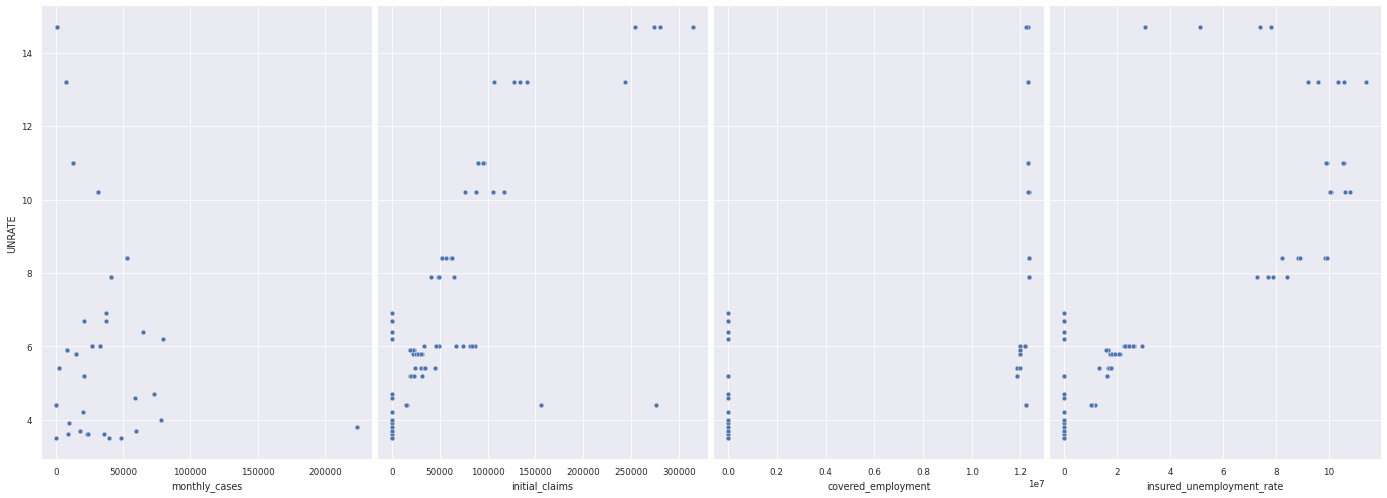

In [194]:
# visualize the relationship between the features and the response using scatterplots
p = sns.pairplot(df5, x_vars=['monthly_cases','initial_claims','covered_employment', "insured_unemployment_rate"], y_vars='UNRATE', size=7, aspect=0.7)

Run regression to calculate residuals

In [97]:
x = df1[["Number_of_cases"]]
y = df1[["UNRATE"]]

In [98]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(x)

In [99]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 0,test_size=0.25)

In [100]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import linear_model

regr = linear_model.LinearRegression()
regr.fit(X_train,y_train)
y_pred = regr.predict(X_test)

In [101]:
regr

LinearRegression()

In [102]:
print("R squared: {}".format(r2_score(y_true=y_test,y_pred=y_pred)))

R squared: 0.5214892590807094


In [131]:
y_pred1 = regr.predict(X_train)
print("R squared: {}".format(r2_score(y_true=y_train,y_pred=y_pred1)))

R squared: 0.4819565478480524


Our model explains only 50% of the variance of the target with the predictor. And this is expected. Because in the real world, our independence assumption does not hold and this is a very hard prediction to make.

In [104]:
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)

In [105]:
y_pred.shape

(9,)

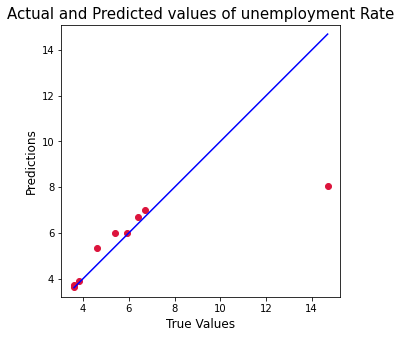

In [116]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, c='crimson')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=12)
plt.ylabel('Predictions', fontsize=12)
plt.axis('equal')


plt.title('Actual and Predicted values of unemployment Rate', fontsize=15)
plt.show()

The model fits well on the test data as well.

## 2. Mean of Residuals

Residuals as we know are the differences between the true value and the predicted value. One of the assumptions of linear regression is that the mean of the residuals should be zero. So let's find out.

In [132]:
residuals = y_train.values-y_pred1
mean_residuals = np.mean(residuals)
print("Mean of Residuals {}".format(mean_residuals))

Mean of Residuals -1.8503717077085943e-16


Very close to zero so all good here.

## 3. Check for Homoscedasticity

Homoscedasticity means that the residuals have equal or almost equal variance across the regression line. By plotting the error terms with predicted terms we can check that there should not be any pattern in the error terms.

In [136]:
type(residuals)
residuals = np.ravel(residuals)
residuals.shape

(24,)

In [137]:
y_pred1 = np.ravel(y_pred1)
y_pred1.shape

(24,)

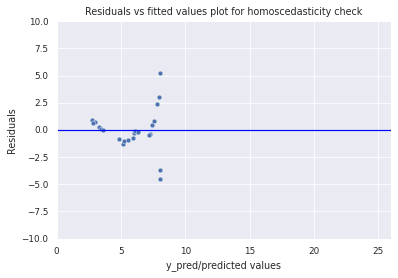

In [199]:
p = sns.scatterplot(y_pred1,residuals)

plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
plt.ylim(-10,10)
plt.xlim(0,26)
p = sns.lineplot([0,26],[0,0],color='blue')

p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

In [139]:
import statsmodels.stats.api as sms
from statsmodels.compat import 
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(residuals, X_train)
lzip(name, test)

[('F statistic', 2.753919977075056), ('p-value', 0.053723130052486676)]

# 4. Check for Normality of error terms/residuals

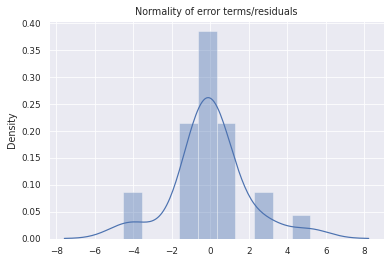

In [200]:
p = sns.distplot(residuals,kde=True)
p = plt.title('Normality of error terms/residuals')

The residual terms look very symmetrical and kind of normally distributed. 

#### The assumptions of linearity are satisfied. So we move on to checking of the regression coefficient is significant

## t test for significance of the regression coefficient

The beta coefficient tells us the unit change in the outcome variable for every 1 unit if change in the independent variable. The t-test assesses whether the beta coefficient is significantly different from zero

In [148]:
import statsmodels.api as sm
from scipy import stats

covid_cases = sm.add_constant(X_train)
est = sm.OLS(y_train, covid_cases)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                 UNRATE   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     20.47
Date:                Mon, 12 Dec 2022   Prob (F-statistic):           0.000168
Time:                        09:15:56   Log-Likelihood:                -49.068
No. Observations:                  24   AIC:                             102.1
Df Residuals:                      22   BIC:                             104.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7615      0.399     14.448      0.0

In [197]:
#Output intermediate dataset 
df5.to_csv("Intermediate_data.csv")